PROCESADO DE IMAGENES:

1. Cargar librerías


Cargamos archivo de imagen

You are facing this issue since you are reading the image with opencv and opencv reads and displays an image as BGR format instead of RGB color format. Whereas matplotlib uses RGB color format to display image

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from line import Line
from processor import ImageProcessor
from tracker import Tracker

# leer imagen de la camara de la raspberry en /dev/video0
camera = cv2.VideoCapture('/dev/video0', cv2.CAP_V4L)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
# leer un frame
ret, frame = camera.read()
cv2.imwrite('frame_nada.jpg', frame)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Ruta de la imagen
ruta_imagen_recta = "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/frame_recta.jpg"
ruta_imagen_curva = "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/frame_curva_1.jpg"
ruta_imagen_nada = "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/frame_nada.jpg"
# Cargar la imagen en color
frame = cv2.imread(ruta_imagen_recta)
# Convertir a RGB para mostrar
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


frame_curva = cv2.imread(ruta_imagen_curva)
frame_curva = cv2.cvtColor(frame_curva, cv2.COLOR_BGR2RGB)

frame_nada = cv2.imread(ruta_imagen_nada)
frame_nada = cv2.cvtColor(frame_nada, cv2.COLOR_BGR2RGB)



Mostrar Imagen

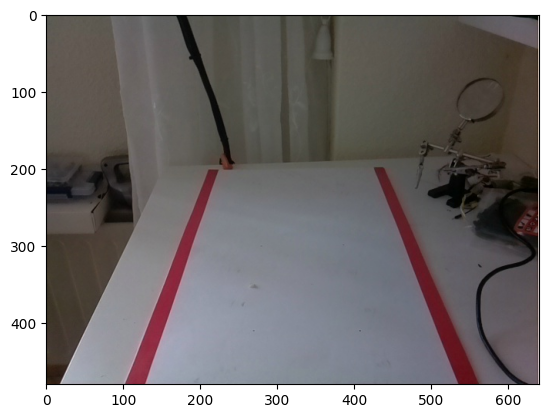

In [2]:
plt.imshow(frame_rgb)
plt.show()

IMAGEN BINARIA:

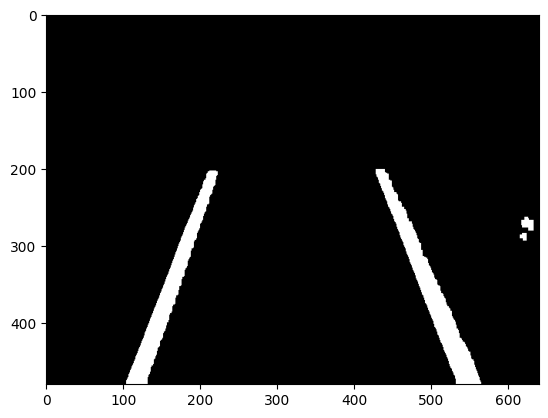

In [3]:
processor = ImageProcessor((640, 480), 20)
# Define the average positions for the left and right lanes.
averageLeft = np.poly1d(np.array([-0.3756, 292.7]))
averageRight = np.poly1d(np.array([0.4277, 348.6]))
#out = processor.process(frame_rgb)
# Convertir la imagen a HSV
imagen_hsv = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2HSV)

# Definir los valores de HSV para la detección del color rojo
lower_hsv = np.array([130, 55, 0])
upper_hsv = np.array([179, 255, 255])

# Aplicar las máscaras HSV a la imagen
mask = cv2.inRange(imagen_hsv, lower_hsv, upper_hsv)

# Convertir la máscara a una imagen binaria 
imagen_binaria = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]

# Definir el kernel para las operaciones morfológicas
kernel = np.ones((5,5), np.uint8)  # Puedes ajustar el tamaño del kernel según tus necesidades

# Aplicar cierre morfológico para eliminar líneas finas
cierre = cv2.morphologyEx(imagen_binaria, cv2.MORPH_CLOSE, kernel)

# (Opcional) Aplicar apertura morfológica para limpiar ruido restante
binary = cv2.morphologyEx(cierre, cv2.MORPH_OPEN, kernel)

plt.imshow(binary, cmap='gray')
plt.show()

Canny:

threshold1 (Umbral Inferior): Este es el valor mínimo de gradiente de intensidad para que un punto sea considerado como un borde. Cualquier cambio en la intensidad por debajo de este valor no se considera como un borde.

threshold2 (Umbral Superior): Este es el valor máximo de gradiente de intensidad para que un punto sea considerado como un borde. Cualquier cambio en la intensidad por encima de este valor se considera definitivamente como un borde.

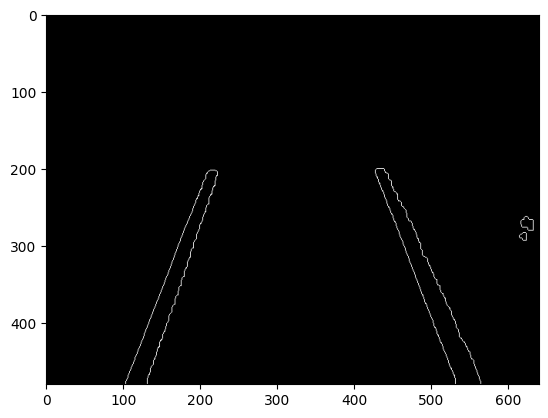

In [4]:
canny = cv2.Canny(binary, threshold1=20, threshold2=40)
plt.imshow(canny, cmap='gray')
plt.show()

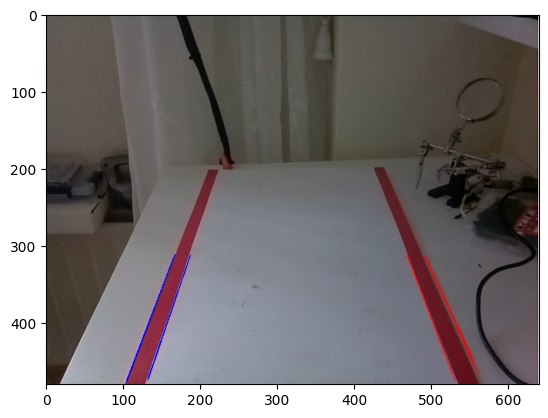

In [5]:
processed_frame = processor.process(frame_rgb)
plt.imshow(processed_frame)
plt.show()

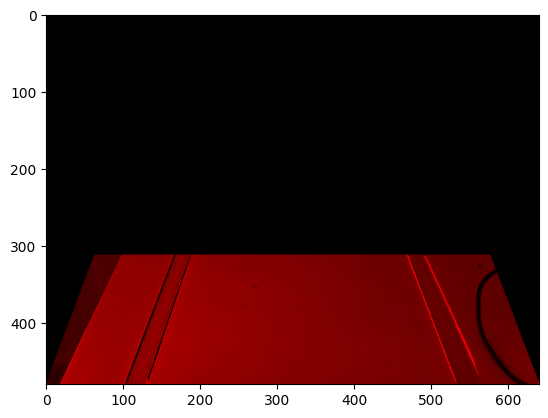

In [6]:
roi = processor.doRegionOfInterest(frame_rgb)
plt.imshow(roi)
plt.show()

Coeficientes de left:   
-0.3752 x + 292.4
Coeficientes de right:   
0.4273 x + 348.2


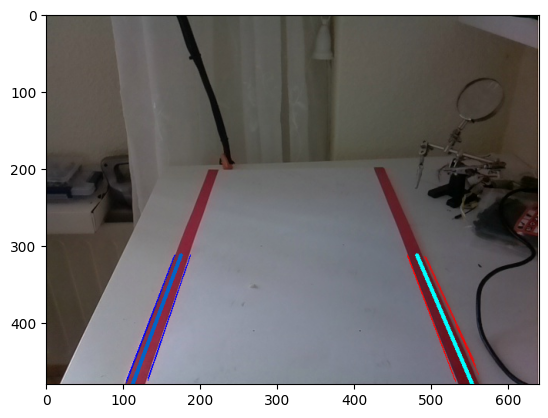

In [7]:
# 3. Passes the found lanes to the Kalman Filter.
rightTracker = Tracker()
leftTracker = Tracker()
left = leftTracker.add(processor.left.poly)
right = rightTracker.add(processor.right.poly)

print('Coeficientes de left: ', left)
print('Coeficientes de right: ', right)

# 4. Draws the unfiltered lanes.
processor.drawPoly(processed_frame, left, (0, 100, 200))
processor.drawPoly(processed_frame, right, (0, 255, 255))

plt.imshow(processed_frame)
plt.show()

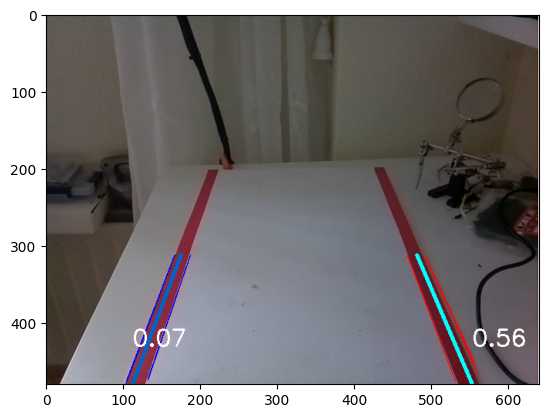

In [8]:
# Calculates the error on both lanes.
y0 = processor.roiY[0] * processor.h
leftError = averageLeft(y0) - left(y0)
rightError = averageRight(y0) - right(y0)
averageError = (leftError + rightError) / 2

cv2.putText(processed_frame, '%.2f' % (leftError), (int(averageLeft(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(processed_frame, '%.2f' % (rightError), (int(averageRight(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(processed_frame)
plt.show()

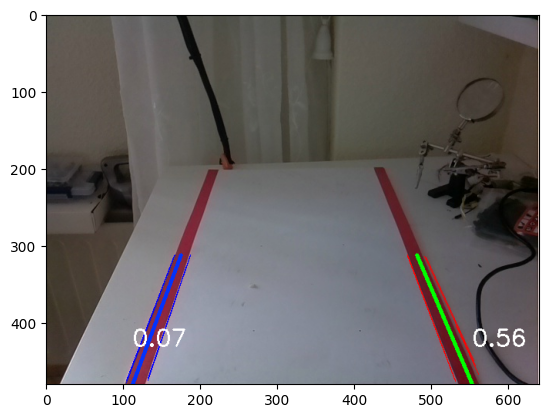

In [9]:
# 4. Draws the output of the Kalman Filter.
processor.drawPoly(processed_frame, left, (0, 50, 255))
processor.drawPoly(processed_frame, right, (0, 255, 0))
plt.imshow(processed_frame)
plt.show()

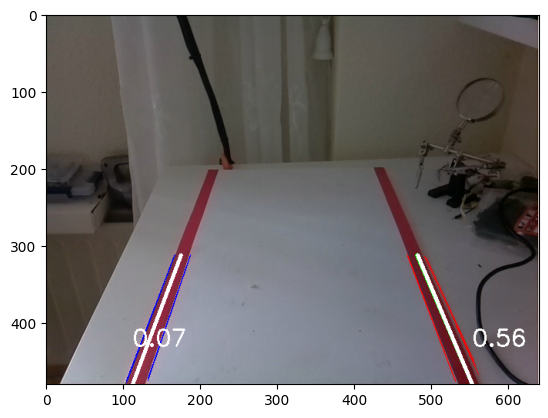

In [10]:
processor.drawPoly(frame_rgb, averageLeft, (255, 255, 255))
processor.drawPoly(frame_rgb, averageRight, (255, 255, 255))

plt.imshow(frame_rgb)
plt.show()

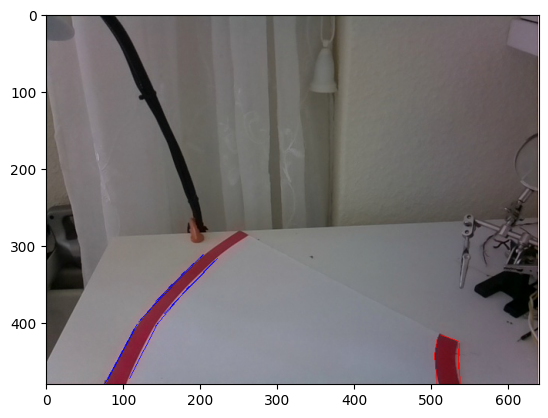

In [9]:
processed_curva = processor.process(frame_curva)
plt.imshow(processed_curva)
plt.show()

Coeficientes de left:   
-0.3752 x + 292.4
Coeficientes de right:   
0.4273 x + 348.2


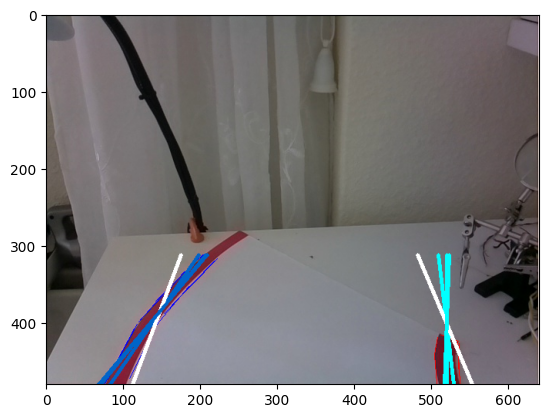

In [12]:
left_curva = leftTracker.add(processor.left.poly)
right_curva = rightTracker.add(processor.right.poly)

print('Coeficientes de left: ', left)
print('Coeficientes de right: ', right)


# 4. Draws the unfiltered lanes.
processor.drawPoly(frame_curva, averageLeft, (255, 255, 255))
processor.drawPoly(frame_curva, averageRight, (255, 255, 255))
processor.drawPoly(frame_curva, left_curva, (0, 100, 200))
processor.drawPoly(frame_curva, right_curva, (0, 255, 255))
plt.imshow(frame_curva)
plt.show()

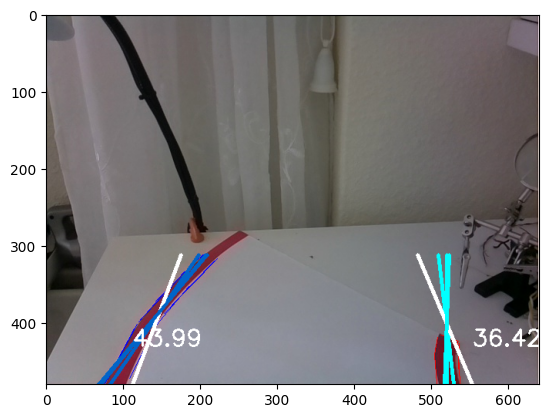

In [14]:
# Calculates the error on both lanes.
y0 = processor.roiY[0] * processor.h
leftError_curva = averageLeft(y0) - left_curva(y0)
rightError_curva = averageRight(y0) - right_curva(y0)
averageError_curva = (leftError_curva + rightError_curva) / 2

cv2.putText(frame_curva, '%.2f' % (leftError_curva), (int(averageLeft(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(frame_curva, '%.2f' % (rightError_curva), (int(averageRight(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(frame_curva)
plt.show()

In [17]:
# calcular angulo de giro en funcion del offset:
# si el offset es positivo, el coche debe girar a la derecha
# si el offset es negativo, el coche debe girar a la izquierda
# si el offset es 0, el coche debe ir recto

proporcion_error_angulo = 0.5  # Grados de giro por unidad de error

# Calcula el ángulo de giro necesario basado en el error promedio
angulo_giro = averageError_curva * proporcion_error_angulo

# Ajusta el ángulo de giro según la dirección del error
# Si el error es positivo, el coche está a la derecha de donde debería estar, por lo que giramos hacia la izquierda (y viceversa).
# Nota: Este ajuste depende de cómo definas la dirección positiva/negativa en tu sistema.

print(f"Ángulo de giro necesario: {angulo_giro} grados")


Ángulo de giro necesario: 20.10395105457531 grados


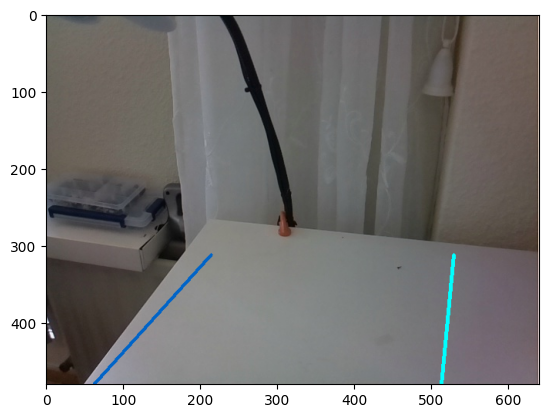

In [14]:
processed_nada = processor.process(frame_nada)
plt.imshow(processed_nada)
plt.show()

Coeficientes de left:   
-1.128 x + 582.9
Coeficientes de right:   
-0.3168 x + 648.7


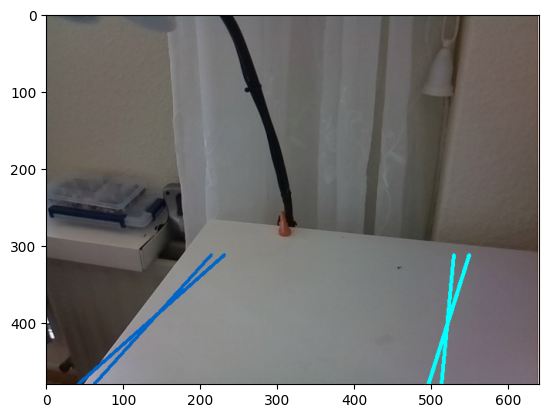

In [15]:
left_nada = leftTracker.add(processor.left.poly)
right_nada = rightTracker.add(processor.right.poly)

print('Coeficientes de left: ', left_nada)
print('Coeficientes de right: ', right_nada)


# 4. Draws the unfiltered lanes.
processor.drawPoly(frame_nada, left_nada, (0, 100, 200))
processor.drawPoly(frame_nada, right_nada, (0, 255, 255))
plt.imshow(frame_nada)
plt.show()